In [ ]:
pip install --upgrade datasets

In [ ]:
from datasets import load_dataset

mnist = load_dataset("mnist")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/6.97k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/15.6M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/2.60M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/60000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [ ]:
print(mnist["train"][0])

{'image': <PIL.PngImagePlugin.PngImageFile image mode=L size=28x28 at 0x7D19ED77D4D0>, 'label': 5}


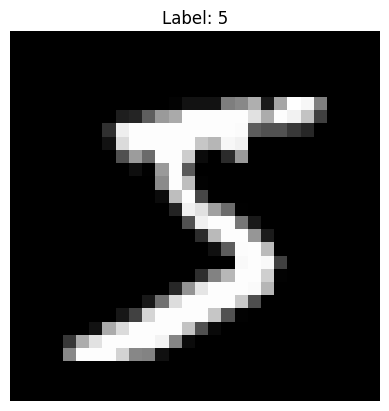

In [ ]:
import matplotlib.pyplot as plt

image = mnist["train"][0]["image"]
label = mnist["train"][0]["label"]

plt.imshow(image, cmap="gray")
plt.title(f"Label: {label}")
plt.axis("off")
plt.show()

In [ ]:
pip install torch torchvision datasets scikit-learn matplotlib

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
from datasets import load_dataset
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np
from PIL import Image


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
dataset = load_dataset("mnist")


transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

def transform_data(example):

    img = np.array(example["image"], dtype=np.float32) / 255.0
    img_tensor = torch.tensor(img).unsqueeze(0)
    img_tensor = (img_tensor - 0.5) / 0.5
    return {"pixel_values": img_tensor}


dataset = load_dataset("mnist")
dataset = dataset.with_transform(transform_data)


print("Expected shape:", dataset["train"][0]["pixel_values"].shape)






Expected shape: torch.Size([1, 28, 28])


In [ ]:
def collate_fn(batch):

    return {"pixel_values": torch.stack([x["pixel_values"] for x in batch])}


In [ ]:
train_loader = DataLoader(
    dataset["train"],
    batch_size=128,
    shuffle=True,
    collate_fn=collate_fn
)

In [ ]:
for batch in train_loader:
    print(batch["pixel_values"].shape)
    break

torch.Size([1, 128, 28, 28])


In [ ]:
batch_size = 128

train_loader = DataLoader(dataset['train'], batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset['test'], batch_size=batch_size)

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self, encoding_dim=64):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 256),
            nn.ReLU(),
            nn.Linear(256, encoding_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 28*28),
            nn.Tanh()
        )

    def forward(self, x):
        z = self.encoder(x)
        out = self.decoder(z)
        return out, z


In [ ]:
print(imgs.shape)
print(imgs_resized.shape)
print(imgs_flat.shape)

torch.Size([1, 128, 28, 28])
torch.Size([1, 128, 28, 28])
torch.Size([1, 100352])


In [ ]:
import torch.nn.functional as F

model = Autoencoder(encoding_dim=64).to(device)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

epochs = 10
for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    for batch in train_loader:
        imgs = batch["pixel_values"].to(device)


        imgs = imgs.squeeze(0)
        imgs = imgs.unsqueeze(1)

        imgs_resized = F.interpolate(imgs, size=(28, 28), mode='bilinear', align_corners=False)

        imgs_flat = imgs_resized.view(imgs_resized.size(0), -1)


        outputs, _ = model(imgs_flat)
        loss = criterion(outputs, imgs_flat)


        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch + 1}, Loss: {running_loss / len(train_loader):.4f}")



Epoch 1, Loss: 0.1016
Epoch 2, Loss: 0.0373
Epoch 3, Loss: 0.0288
Epoch 4, Loss: 0.0247
Epoch 5, Loss: 0.0219
Epoch 6, Loss: 0.0199
Epoch 7, Loss: 0.0184
Epoch 8, Loss: 0.0172
Epoch 9, Loss: 0.0164
Epoch 10, Loss: 0.0157


In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np

model.eval()
embeddings = []

with torch.no_grad():
    for batch in test_loader:
        imgs = batch["pixel_values"].to(device)


        imgs = imgs.squeeze(0)
        imgs = imgs.unsqueeze(1)
        imgs_resized = F.interpolate(imgs, size=(28, 28), mode='bilinear', align_corners=False)
        imgs_flat = imgs_resized.view(imgs_resized.size(0), -1)


        _, z = model(imgs_flat)
        embeddings.append(z.cpu().numpy())


embeddings = np.concatenate(embeddings, axis=0)
kmeans = KMeans(n_clusters=10, random_state=42)
clusters = kmeans.fit_predict(embeddings)


score = silhouette_score(embeddings, clusters)
print(f"Silhouette Score: {score:.4f}")


Silhouette Score: 0.0739


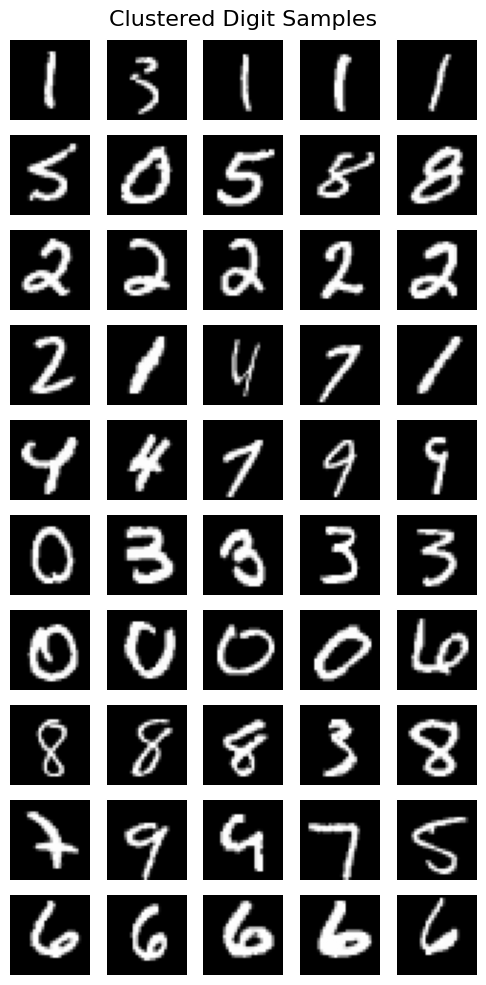

In [ ]:
import matplotlib.pyplot as plt


samples_per_cluster = 5
cluster_samples = {i: [] for i in range(10)}


model.eval()
embeddings = []
all_imgs = []
all_clusters = []

with torch.no_grad():
    for batch in test_loader:
        imgs = batch["pixel_values"].to(device)
        imgs = imgs.squeeze(0)
        imgs = imgs.unsqueeze(1)

        imgs_resized = F.interpolate(imgs, size=(28, 28), mode='bilinear', align_corners=False)
        imgs_flat = imgs_resized.view(imgs_resized.size(0), -1)

        _, z = model(imgs_flat)
        preds = kmeans.predict(z.cpu().numpy())

        embeddings.append(z.cpu().numpy())
        all_imgs.append(imgs_resized.cpu().numpy())
        all_clusters.extend(preds)


all_imgs = np.concatenate(all_imgs, axis=0)
all_clusters = np.array(all_clusters)


for cluster_id in range(10):
    idxs = np.where(all_clusters == cluster_id)[0]
    chosen = np.random.choice(idxs, size=min(samples_per_cluster, len(idxs)), replace=False)
    cluster_samples[cluster_id] = all_imgs[chosen]


fig, axes = plt.subplots(10, samples_per_cluster, figsize=(samples_per_cluster, 10))
fig.suptitle("Clustered Digit Samples", fontsize=16)

for row, (cluster_id, images) in enumerate(cluster_samples.items()):
    for col, img in enumerate(images):
        axes[row, col].imshow(img[0], cmap="gray")
        axes[row, col].axis("off")
        if col == 0:
            axes[row, col].set_ylabel(f"Cluster {cluster_id}", fontsize=10)

plt.tight_layout()
plt.show()
